In [1]:
import sympy as sp
from sympy.abc import t

c_flibe = sp.Function(r"c_\mathrm{FLiBe}")(t)
henry_sol = sp.Symbol("K_H")
diff = sp.Symbol("D")
P = sp.Function("P")(t)
n = sp.Function("n")(t)
V = sp.Symbol("V")
R = sp.Symbol("R")
T = sp.Symbol("T")
c_inf = sp.Symbol(r"c_\infty")
S = sp.Symbol("S")
r = sp.Symbol("r")

t = sp.Symbol("t")

In [2]:
# Henry's law at the surface of the bubble

henry_law = sp.Eq(c_flibe, henry_sol * P)
henry_law

Eq(c_\mathrm{FLiBe}(t), K_H*P(t))

In [3]:
# perfect gas law in bubble
perfect_gas = sp.Eq(P*V, n*R*T)
perfect_gas

Eq(V*P(t), R*T*n(t))

In [4]:
c_flibe_expr = henry_law.subs(P, sp.solve(perfect_gas, P)[0])
c_flibe_expr

Eq(c_\mathrm{FLiBe}(t), K_H*R*T*n(t)/V)

In [5]:
time_diff_c_flibe = sp.Eq(sp.Derivative(c_flibe_expr.lhs, t), sp.Derivative(c_flibe_expr.rhs, t)).simplify()
time_diff_c_flibe

Eq(Derivative(c_\mathrm{FLiBe}(t), t), K_H*R*T*Derivative(n(t), t)/V)

In [6]:
n_dot_expr = sp.Eq(sp.Derivative(n, t), diff*S/r*(c_inf - c_flibe))
n_dot_expr

Eq(Derivative(n(t), t), D*S*(c_\infty - c_\mathrm{FLiBe}(t))/r)

In [7]:
time_diff_c_flibe = time_diff_c_flibe.subs(sp.Derivative(n, t), n_dot_expr.rhs)
time_diff_c_flibe

Eq(Derivative(c_\mathrm{FLiBe}(t), t), D*K_H*R*S*T*(c_\infty - c_\mathrm{FLiBe}(t))/(V*r))

In [8]:
sphere_volume = sp.Rational(4)/sp.Rational(3) * sp.pi * r**3
sphere_surface = sp.Rational(4) * sp.pi * r**2

time_diff_c_flibe = time_diff_c_flibe.subs({V: sphere_volume, S: sphere_surface})
time_diff_c_flibe

Eq(Derivative(c_\mathrm{FLiBe}(t), t), 3*D*K_H*R*T*(c_\infty - c_\mathrm{FLiBe}(t))/r**2)

In [9]:
charac_time = sp.Symbol(r"\tau")
tau_def = sp.Eq(charac_time, 1/(3*diff*henry_sol*R*T/r**2))
tau_def

Eq(\tau, r**2/(3*D*K_H*R*T))

Substituting by $\tau$ gives:

In [10]:
time_diff_c_flibe = time_diff_c_flibe.subs(3*diff*henry_sol*R*T, sp.solve(tau_def, 3*diff*henry_sol*R*T)[0])
time_diff_c_flibe

Eq(Derivative(c_\mathrm{FLiBe}(t), t), (c_\infty - c_\mathrm{FLiBe}(t))/\tau)

In [11]:
c_flibe_time_expr = sp.dsolve(time_diff_c_flibe, c_flibe, ics={c_flibe.subs(t, 0): 0})
c_flibe_time_expr

Eq(c_\mathrm{FLiBe}(t), c_\infty - c_\infty*exp(-t/\tau))

In [12]:
c_flibe_time_expr = sp.Eq(c_flibe_time_expr.lhs, c_flibe_time_expr.rhs.collect(c_inf))
c_flibe_time_expr

Eq(c_\mathrm{FLiBe}(t), c_\infty*(1 - exp(-t/\tau)))

In [13]:
from scipy.integrate import odeint
import numpy as np
import h_transport_materials as htm

ureg = htm.ureg
ureg.setup_matplotlib()

GAS_CONSTANT = 8.314 * ureg.J * ureg.mol**-1 * ureg.K**-1

In [14]:
def model(c_flibe, t, decay_constant):
    c_inf = 1
    dcdt = decay_constant * (c_inf - c_flibe)
    return dcdt

compute_c_flibe = sp.lambdify((charac_time, c_inf, t,), c_flibe_expr.rhs)

In [15]:
diffusivities = htm.diffusivities.filter(material="flibe", isotope="t")
D_0, E_D = diffusivities.mean()
mean_diff = htm.Diffusivity(
    D_0 * diffusivities[0].units,
    E_D * ureg.eV * ureg.particle**-1,
)
print(mean_diff)


        Author: 
        Material: 
        Year: None
        Isotope: None
        Pre-exponential factor: 5.729948226646946e-07 m ** 2 / s
        Activation energy: 0.37535747466879604 eV
        


In [16]:
solubilities = htm.solubilities.filter(material="flibe", isotope="t")
S_0, E_S = solubilities.mean()
mean_sol = htm.Solubility(
    "m-3 Pa-1",
    S_0=S_0 * solubilities[0].units,
    E_S=E_S * ureg.eV * ureg.particle**-1,
)
print(mean_sol)


        Author: 
        Material: 
        Year: None
        Isotope: None
        Pre-exponential factor: 4.757491200400059e+22 particle / Pa / m ** 3
        Activation energy: 0.3627494379691766 eV
        


In [17]:
eval_function = sp.lambdify((diff, henry_sol, R, T, r,), tau_def.rhs)

def compute_characteristic_time(T, radius):
    K_H = mean_sol.value(T.to(ureg.K).magnitude) * mean_sol.units
    D = mean_diff.value(T.to(ureg.K).magnitude) * mean_diff.units
    time = eval_function(D, K_H, GAS_CONSTANT, T.to(ureg.K), radius)
    return time.to(ureg.s)

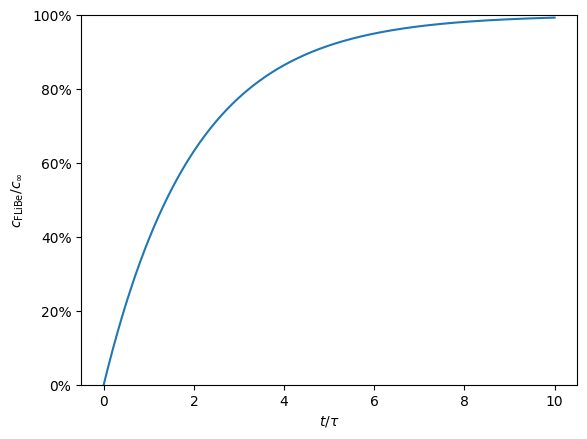

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

c_flibe_0 = 0
tau = 2
t = np.linspace(0, 5 * tau, num=500)

y = odeint(model, c_flibe_0, t, args=(1 / tau,))

plt.plot(t, y, color="tab:blue")

plt.xlabel(r"$t/\tau$")
plt.ylabel("$c_\mathrm{FLiBe}/c_\infty$")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

C:\Users\remidm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\labellines\utils.py:27: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(value, dtype=float)


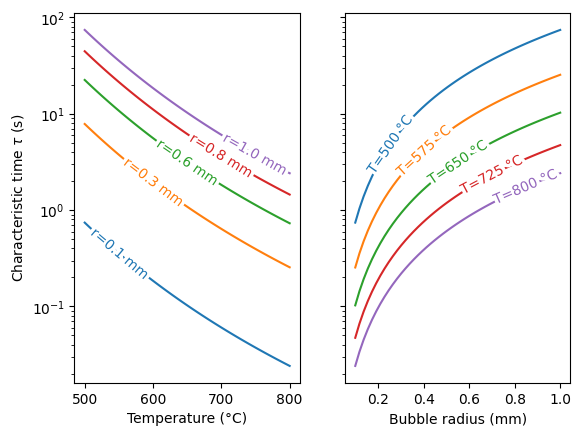

In [19]:
from labellines import labelLines

fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)


# vary temperature
plt.sca(axs[0])
T_range = np.linspace(500, 800) * ureg.degC
radii = np.linspace(0.1, 1, num=5) * ureg.mm

for radius in radii:
    plt.plot(
        T_range,
        compute_characteristic_time(T_range, radius).to(ureg.s),
        label=f"r={radius:~.1f}",
    )

# vary radius
plt.sca(axs[1])

radius_range = np.linspace(0.1, 1) * ureg.mm
temperatures = np.linspace(500, 800, num=5) * ureg.degC

for T in temperatures:
    plt.plot(
        radius_range,
        compute_characteristic_time(T, radius_range).to(ureg.s),
        label=f"T={T:~.0f}",
    )

axs[0].set_ylabel(r"Characteristic time $\tau$ (s)")
axs[0].set_xlabel(f"Temperature ({T_range.units: ~P})")
axs[1].set_xlabel(f"Bubble radius ({radius_range.units: ~P})")
plt.yscale("log")

labelLines(axs[0].get_lines(), zorder=2.5)
labelLines(axs[1].get_lines(), zorder=2.5)
plt.show()

C:\Users\remidm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\ma\core.py:2826: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


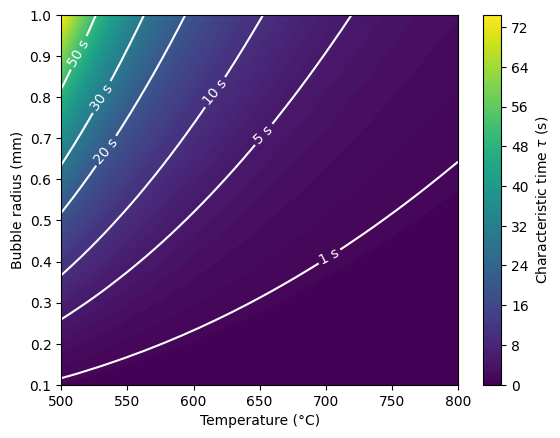

In [20]:
from matplotlib import ticker, cm, colors

XX, YY = np.meshgrid(T_range, radius_range)
ZZ = compute_characteristic_time(XX, YY)
cs = plt.contourf(XX, YY, ZZ, levels=100)
cs2 = plt.contour(
    XX,
    YY,
    ZZ,
    levels=[1, 5, 10, 20, 30, 50],
    colors="white",
)


def fmt(x):
    return f"{x:.0f} {ZZ.units:~P}"


plt.clabel(cs2, cs2.levels, inline=True, fontsize=10, fmt=fmt)

plt.xlabel(f"Temperature ({T_range.units: ~P})")
plt.ylabel(f"Bubble radius ({radius_range.units: ~P})")
cbar = fig.colorbar(cs, label=r"Characteristic time $\tau$ (s)")